In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass 
password = getpass.getpass()
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import neighbors
from sklearn.preprocessing import OneHotEncoder

········


### 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.title AS film
    , f.rental_rate
    , f.rating
    , CONCAT(ac.first_name,' ',ac.last_name) AS actor
    , cat.name AS category
    , i.store_id
    , c.country
    , r.may

FROM film f
LEFT JOIN film_actor fa
    USING (film_id)
LEFT JOIN actor ac
    USING (actor_id)
LEFT JOIN inventory i
    USING (film_id)
JOIN film_category fc
    USING (film_id)
JOIN category cat
    USING (category_id)
LEFT JOIN (SELECT*
                    , DATE_FORMAT(rental_date, '%%m') AS may
            FROM rental
            WHERE DATE_FORMAT(rental_date, '%%m') = 05
            ) r
    USING (inventory_id)
LEFT JOIN customer cst
    USING (customer_id)
LEFT JOIN address a
    USING (address_id)
LEFT JOIN city cty
    USING (city_id)
LEFT JOIN country c
    USING (country_id)

GROUP BY film;

'''

sakila = pd.read_sql_query(query, engine)
sakila.head()

,film,rental_rate,rating,actor,category,store_id,country,may
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None,None
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Brazil,05
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Germany,05
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None,None
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,None,None


### 2. Create a query to get the list of films and a boolean indicating if it was rented last month (May 2005). This would be our target variable.


In [3]:
sakila['rented_may'] = np.where(sakila['may'] == '05', True, False)
sakila.shape

(1000, 9)

### 3. Read the data into a Pandas dataframe.

In [4]:
sakila = sakila.drop(['may'], axis = 1)
sakila['store_id'] = sakila['store_id'].astype('object')

print(type(sakila))
print(sakila.shape)
sakila.head(20)

<class 'pandas.core.frame.DataFrame'>
(1000, 8)


,film,rental_rate,rating,actor,category,store_id,country,rented_may
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None,False
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Brazil,True
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Germany,True
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None,False
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,None,False
5,BERETS AGENT,2.99,PG-13,GRACE MOSTEL,Action,1.0,None,False
6,BRIDE INTRIGUE,0.99,G,ANGELA HUDSON,Action,1.0,None,False
7,BULL SHAWSHANK,0.99,NC-17,NICK WAHLBERG,Action,1.0,None,False
8,CADDYSHACK JEDI,0.99,NC-17,ED CHASE,Action,2.0,Turkey,True
9,CAMPUS REMEMBER,2.99,R,MATTHEW JOHANSSON,Action,1.0,None,False


### 4. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [5]:
y = sakila['rented_may']
X = sakila.drop('rented_may', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X.dtypes

film            object
rental_rate    float64
rating          object
actor           object
category        object
store_id        object
country         object
dtype: object

In [7]:
X_train_num = X_train.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)
X_train_cat = X_train_cat.drop(['film', 'actor', 'country'], axis = 1)

In [8]:
transformer = MinMaxScaler().fit(X_train_num) 
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns = X_train_num.columns)
X_train_norm.head()

,rental_rate
0,1.0
1,0.0
2,0.0
3,0.5
4,1.0


In [9]:
hot_encoder = OneHotEncoder(drop='first').fit(X_train_cat)
hot_encoded = hot_encoder.transform(X_train_cat).toarray()
hot_cols = hot_encoder.get_feature_names(input_features=X_train_cat.columns)
hot_encoded = pd.DataFrame(hot_encoded, columns = [i.lower() for i in hot_cols])
print(hot_encoded.shape)
hot_encoded.head()

(800, 21)


,rating_nc-17,rating_pg,rating_pg-13,rating_r,category_animation,category_children,category_classics,category_comedy,category_documentary,category_drama,...,category_foreign,category_games,category_horror,category_music,category_new,category_sci-fi,category_sports,category_travel,store_id_2.0,store_id_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


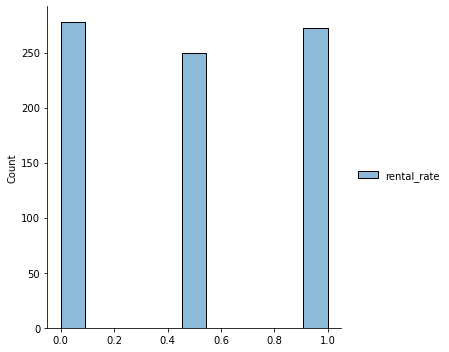

In [10]:
sns.displot(X_train_norm)
plt.show()

In [11]:
X_train_transformed = np.concatenate([X_train_norm, hot_encoded], axis=1)
pd.DataFrame(X_train_transformed)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
798,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 5. Create a logistic regression model to predict this variable from the cleaned data.

In [12]:
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [13]:
X_test_num = X_test.select_dtypes(include = np.number)
X_test_cat = X_test.select_dtypes(include = object)
X_test_cat = X_test_cat.drop(['film', 'actor', 'country'], axis = 1)

In [14]:
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized, columns = X_test_num.columns)
X_test_norm.head()

,rental_rate
0,1.0
1,1.0
2,0.5
3,0.0
4,1.0


In [15]:
hot_encoder

OneHotEncoder(drop='first')

In [16]:
hot_encoded_t = hot_encoder.transform(X_test_cat).toarray()
hot_cols_t = hot_encoder.get_feature_names(input_features=X_test_cat.columns)
hot_encoded_t = pd.DataFrame(hot_encoded_t, columns = [i.lower() for i in hot_cols_t])
print(hot_encoded_t.shape)
hot_encoded_t.head()

(200, 21)


,rating_nc-17,rating_pg,rating_pg-13,rating_r,category_animation,category_children,category_classics,category_comedy,category_documentary,category_drama,...,category_foreign,category_games,category_horror,category_music,category_new,category_sci-fi,category_sports,category_travel,store_id_2.0,store_id_nan
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X_test_transformed = np.concatenate([X_test_norm, hot_encoded_t], axis=1)
pd.DataFrame(X_test_transformed)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.775

In [19]:
confusion_matrix(y_test, predictions)

array([[155,   0],
       [ 45,   0]], dtype=int64)

In [20]:
# y_test_df = pd.DataFrame(y_test)
# y_test_df.reset_index(inplace = True)
# y_test_df.drop('index', axis = 1, inplace = True)
# predictions_df = pd.DataFrame(predictions)
# results = pd.concat([y_test_df, predictions_df], axis = 1)
# results.rename(columns = {'rented_may': 'y_test value', 0: 'guess'})

In [21]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.71

In [22]:
y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace = True)
y_test_df.drop('index', axis = 1, inplace = True)
predictions_df = pd.DataFrame(predictions)
predictions_clf_df = pd.DataFrame(predictions_clf)
results = pd.concat([y_test_df, predictions_df, predictions_clf_df], axis = 1)
results.columns = ['y', 'guess', 'guess_clf']
results

,y,guess,guess_clf
0,False,False,True
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,True
...,...,...,...
195,False,False,False
196,False,False,False
197,True,False,False
198,False,False,False


In [23]:
confusion_matrix(y_test, predictions_clf)

array([[136,  19],
       [ 39,   6]], dtype=int64)

In [24]:
pd.Series(y_test).value_counts()

False    155
True      45
Name: rented_may, dtype: int64

In [25]:
pd.Series(predictions_clf).value_counts()

False    175
True      25
dtype: int64

In [26]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.title AS film
    , f.rental_rate
    , f.rating
    , CONCAT(ac.first_name,' ',ac.last_name) AS actor
    , cat.name AS category
    , i.store_id
    , c.country
    , r.june

FROM film f
LEFT JOIN film_actor fa
    USING (film_id)
LEFT JOIN actor ac
    USING (actor_id)
LEFT JOIN inventory i
    USING (film_id)
JOIN film_category fc
    USING (film_id)
JOIN category cat
    USING (category_id)
LEFT JOIN (SELECT*
                    , DATE_FORMAT(rental_date, '%%m') AS june
            FROM rental
            WHERE DATE_FORMAT(rental_date, '%%m') = 06
            ) r
    USING (inventory_id)
LEFT JOIN customer cst
    USING (customer_id)
LEFT JOIN address a
    USING (address_id)
LEFT JOIN city cty
    USING (city_id)
LEFT JOIN country c
    USING (country_id)

GROUP BY film;

'''

sakila_june = pd.read_sql_query(query, engine)
sakila_june.head()

,film,rental_rate,rating,actor,category,store_id,country,june
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None,None
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Finland,06
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Philippines,06
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None,None
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,Canada,06


In [27]:
sakila_june['rented_june'] = np.where(sakila_june['june'] == '06', True, False)
sakila_june.shape
sakila_june = sakila_june.drop(['june'], axis = 1)
sakila_june['store_id'] = sakila_june['store_id'].astype('object')

In [28]:
y_j = sakila_june['rented_june']
X_j = sakila_june.drop('rented_june', axis=1)

In [29]:
X_j_num = X_j.select_dtypes(include = np.number)
X_j_cat = X_j.select_dtypes(include = object)
X_j_cat = X_j_cat.drop(['film', 'actor', 'country'], axis = 1)

In [30]:
X_normalized_j = transformer.transform(X_j_num)
X_norm_j = pd.DataFrame(X_normalized_j, columns = X_j_num.columns)

In [31]:
hot_encoded = hot_encoder.transform(X_j_cat).toarray()
hot_cols_j = hot_encoder.get_feature_names(input_features=X_j_cat.columns)
hot_encoded_j = pd.DataFrame(hot_encoded, columns = [i.lower() for i in hot_cols])

In [32]:
X_j_transformed = np.concatenate([X_norm_j, hot_encoded_j], axis=1)

In [33]:
predictions_j = classification.predict(X_j_transformed)
classification.score(X_j_transformed, y_j)

0.552

In [34]:
pd.Series(y_j).value_counts()

False    552
True     448
Name: rented_june, dtype: int64

In [35]:
pd.Series(predictions_j).value_counts()

False    1000
dtype: int64

In [36]:
predictions_clf_j = clf.predict(X_j_transformed)
clf.score(X_j_transformed, y_j)

0.594

In [37]:
y_j_df = pd.DataFrame(y_j)
y_j_df.reset_index(inplace = True)
y_j_df.drop('index', axis = 1, inplace = True)
predictions_df_j = pd.DataFrame(predictions_j)
predictions_clf_j = pd.DataFrame(predictions_clf_j)
results_j = pd.concat([y_j_df, predictions_df_j, predictions_clf_j], axis = 1)
results_j.columns = ['y_june', 'guess_june', 'guess_clf_june']
results_j

,y_june,guess_june,guess_clf_june
0,False,False,False
1,True,False,False
2,True,False,False
3,False,False,False
4,True,False,False
...,...,...,...
995,True,False,True
996,True,False,False
997,True,False,False
998,False,False,False


### 6. Evaluate the results.